In [1]:
# %%
import os
import numpy as np
import torch
import h5py
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from tqdm import tqdm

num_z = 45
num_alpha = 16
num_r = 9

data_dir = "/beegfs/desy/user/kaechben/calochallenge/"
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
# Custom transformer for logit transformation
class LogitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.log(X / (1 - X))
    def inverse_transform(self, X, y=None):
        return 1 / (1 + np.exp(-X))
# Custom transformer for inverse logit transformation
class DQ(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X=X+np.random.rand(*X.shape)
        return X
    def inverse_transform(self, X, y=None):
        X=np.floor(X)

        return X

def shower_to_pc(args):
    shower, E = args
    shower, E = shower.clone(), E.clone()
    shower = shower.reshape(num_z, num_alpha, num_r).to_sparse()
    # assert shower.shape == etas.shape == phis.shape    
    #shower=torch.tensor(showers[0].reshape(45,16,9))
    shower=shower.to_sparse()
    pc=torch.cat((shower.values().reshape(-1,1),shower.indices().T.float()),1)
    # raise
    # h_energy = shower[idxs]
    # z, alpha, r = idxs
    # z=z.float()
    # alpha=alpha.float()
    # r=r.float()
    # hitsperlayer = (shower != 0).float().sum((1, 2))
    # assert (
    #     hitsperlayer[hitsperlayer != 0]
    #     == torch.unique(idxs[0], sorted=True, return_counts=True)[1]
    # ).all()
    # zp = z - num_z / 2
    # theta = torch.arctan(zp / r)
    # eta = torch.log(torch.tan(theta / 2))
    # phi = alpha
    # pc = torch.stack([h_energy, r, alpha, z,]).T
    return {
        "Egen": torch.tensor(E).squeeze().clone(),
        "E_z_alpha_r": pc.clone(),
    }


# %%
# creating instance of HighLevelFeatures class to handle geometry based on binning file
class ScalerBase:
    def __init__(self, transfs, featurenames: list[str]) -> None:
        self.transfs = transfs
        self.featurenames = featurenames
        self.n_features = len(self.transfs)

        self.scalerpath = Path(data_dir) / "scaler.gz"
        if self.scalerpath.is_file():
            self.transfs = joblib.load(self.scalerpath)

    def save_scalar(self, pcs: torch.Tensor):
        # The features need to be converted to numpy immediatly
        # otherwise the queuflow afterwards doesnt work
        assert pcs.dim() == 2
        assert self.n_features == pcs.shape[1]
        pcs = pcs.detach().cpu().numpy()
        self.plot_scaling(pcs)

        assert pcs.shape[1] == self.n_features
        pcs = np.hstack(
            [
                transf.fit_transform(arr.reshape(-1, 1))
                for arr, transf in zip(pcs.T, self.transfs)
            ]
        )
        self.plot_scaling(pcs, True)

        joblib.dump(self.transfs, self.scalerpath)

    def transform(self, pcs: np.ndarray):
        assert len(pcs.shape) == 2
        assert pcs.shape[1] == self.n_features
        return np.hstack(
            [
                transf.fit_transform(arr.reshape(-1, 1))
                for arr, transf in zip(pcs.T, self.transfs)
            ]
        )

    def inverse_transform(self, pcs: torch.Tensor):
        assert pcs.shape[-1] == self.n_features
        orgshape = pcs.shape
        dev = pcs.device
        pcs = pcs.to("cpu").detach().reshape(-1, self.n_features).numpy()

        t_stacked = np.hstack(
            [
                transf.inverse_transform(arr.reshape(-1, 1))
                for arr, transf in zip(pcs.T, self.transfs)
            ]
        )
        return torch.from_numpy(t_stacked.reshape(*orgshape)).float().to(dev)

    def plot_scaling(self, pcs, post=False):
        for k, v in zip(self.featurenames, pcs.T):
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.hist(v, bins=500)
            fig.savefig(
                Path(data_dir) / f"{k}_post.png"
                if post
                else Path(data_dir) / f"{k}_pre.png"
            )
            plt.close(fig)
# %%

# %%

In [13]:


for mode in ["train", "test"]:
    data_dir = "/beegfs/desy/user/kaechben/calochallenge/"
    electron_file = h5py.File(
        data_dir + {"train": "dataset_2_1.hdf5", "test": "dataset_2_2.hdf5"}[mode], "r"
    )
    energies = electron_file["incident_energies"][:]
    showers = electron_file["showers"][:]
    outL = [
        shower_to_pc(e)
        for e in tqdm(zip(torch.tensor(showers), torch.tensor(energies)))
    ]
    outD = {k: [e[k] for e in outL] for k in outL[0].keys()}
    if mode == "train":
        scalar = ScalerBase(
            transfs=[
                PowerTransformer(method="box-cox", standardize=True),
                Pipeline([('dequantization', DQ()),('minmax_scaler', MinMaxScaler(feature_range=(1e-5, 1-1e-5))),('logit_transformer', LogitTransformer()),("standard_scaler",StandardScaler())]),
                Pipeline([('dequantization', DQ()),('minmax_scaler', MinMaxScaler(feature_range=(1e-5, 1-1e-5))),('logit_transformer', LogitTransformer()),("standard_scaler",StandardScaler())]),
                Pipeline([('dequantization', DQ()),('minmax_scaler', MinMaxScaler(feature_range=(1e-5, 1-1e-5))),('logit_transformer', LogitTransformer()),("standard_scaler",StandardScaler())])]
                ,
            featurenames=["E", "z", "alpha", "r"],
        )
        arr = torch.vstack(outD["E_z_alpha_r"])
        scalar.save_scalar(arr)

        for ievent in tqdm(range(len(outD["E_z_alpha_r"]))):
            outD["E_z_alpha_r"][ievent] = torch.tensor(
                scalar.transform(outD["E_z_alpha_r"][ievent].numpy())
            )
        torch.save(outD, f"{data_dir}pc_{mode}.pt")

0it [00:00, ?it/s]/tmp/ipykernel_219224/1462697200.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "Egen": torch.tensor(E).squeeze().clone(),
100000it [00:44, 2223.92it/s]
100%|██████████| 100000/100000 [15:36<00:00, 106.82it/s]
0it [00:00, ?it/s]/tmp/ipykernel_219224/1462697200.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "Egen": torch.tensor(E).squeeze().clone(),
100000it [00:47, 2088.53it/s]


  0%|          | 0/100000 [00:08<?, ?it/s]


KeyboardInterrupt: 

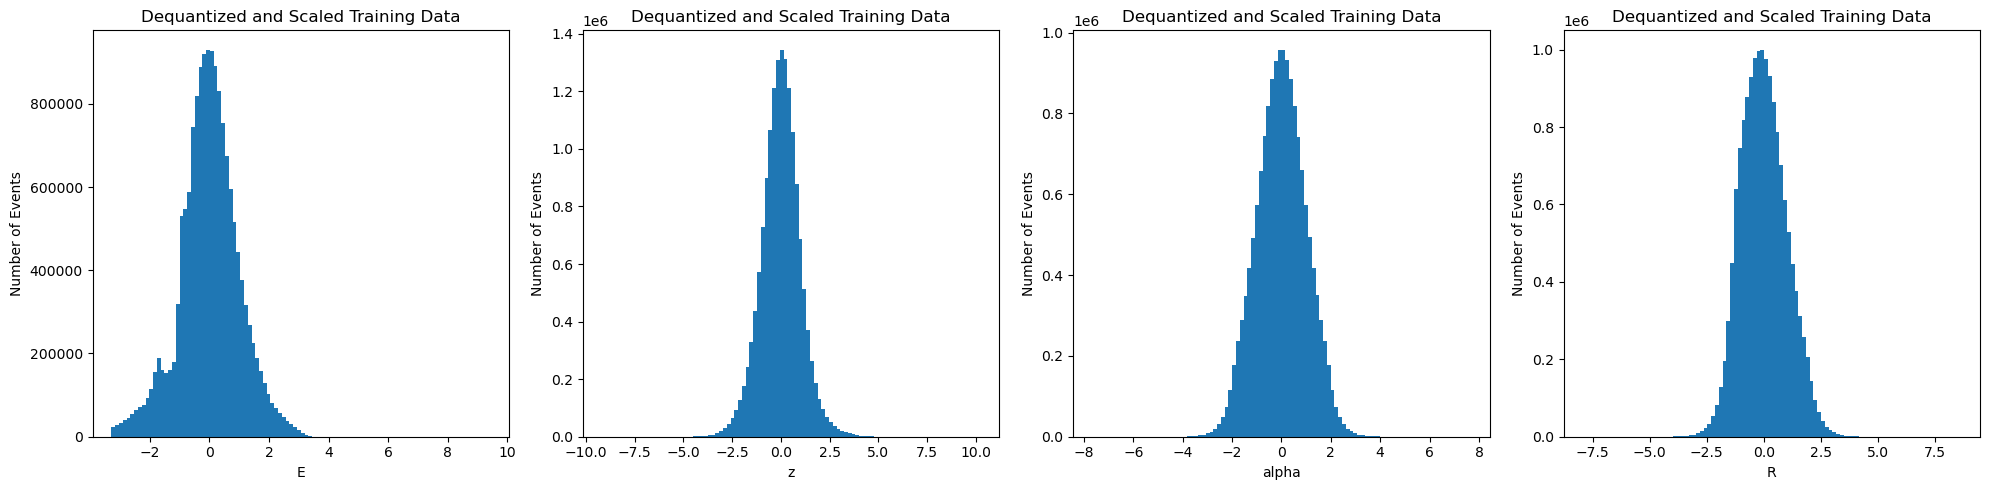

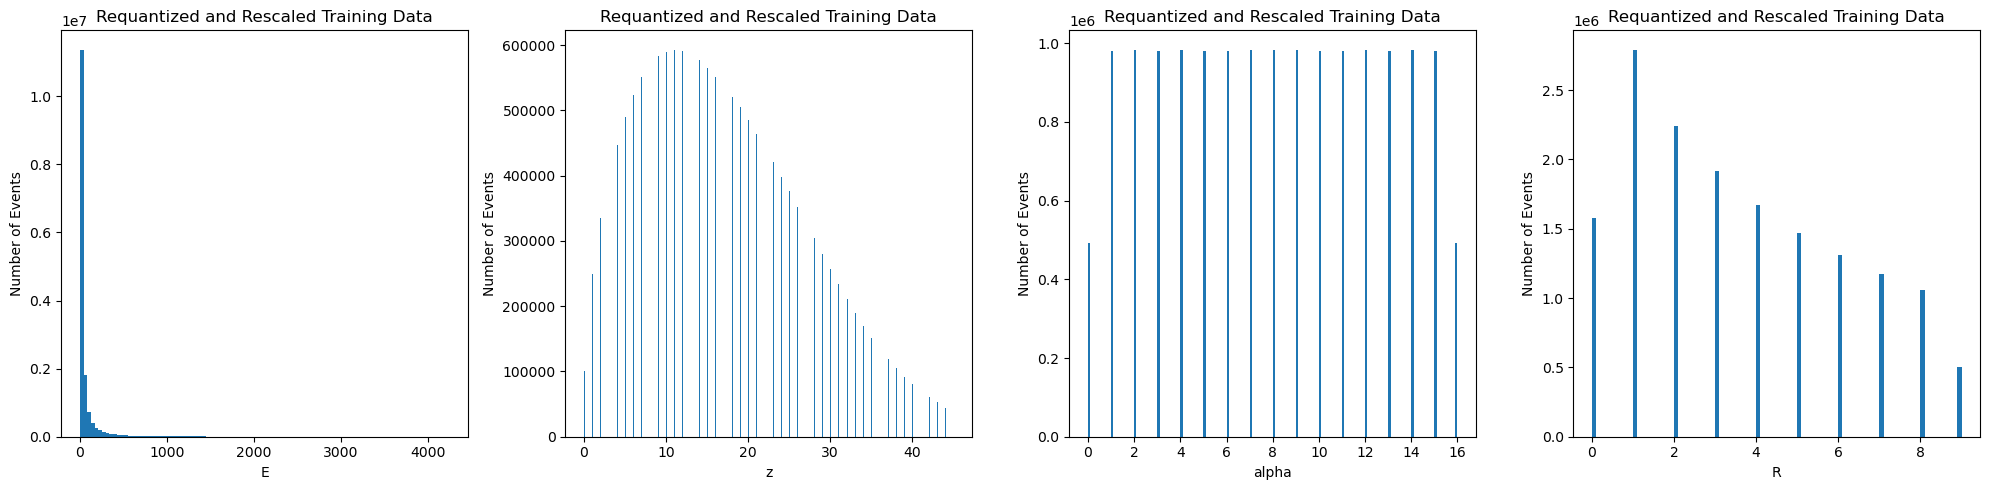

In [8]:
X=ScalerBase.fit_transform(arr.numpy())
fig,ax=plt.subplots(1,4,figsize=(20,5))
bins=[100,10*num_z,10*num_alpha,10*num_r]
for i,col in enumerate(["E","z","alpha","R"]):
    ax[i].hist(X[:,i],bins=100)
    ax[i].set_title("Dequantized and Scaled Training Data")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Number of Events")
plt.tight_layout()
plt.show()
fig,ax=plt.subplots(1,4,figsize=(20,5))
for i,col in enumerate(["E","z","alpha","R"]):
    ax[i].hist(preprocessor_pipeline.inverse_transform(X)[:,i],bins=bins[i])
    ax[i].set_title("Requantized and Rescaled Training Data")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Number of Events")
plt.tight_layout()
plt.show()

